# Skipgram 



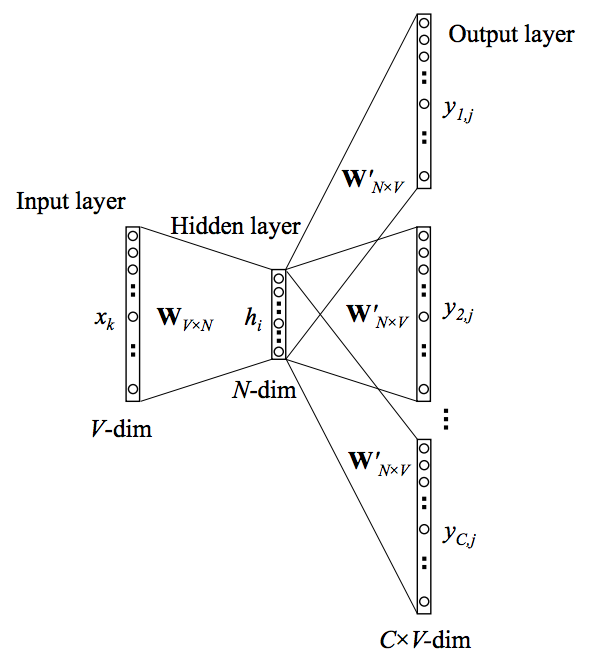

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

In [11]:


torch.manual_seed(1)

CONTEXT_SIZE = 3
EMBEDDING_DIM = 10

def get_key(word_id):
    for key,val in word_to_ix.items():
        if(val == word_id):
            print(key)


def cluster_embeddings(filename,nclusters):
    X = np.load(filename)
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
    center = kmeans.cluster_centers_
    distances = euclidean_distances(X,center)

    for i in np.arange(0,distances.shape[1]):
        word_id = np.argmin(distances[:,i])
        print(word_id)
        get_key(word_id)

def read_data(file_path):
    tokenizer = RegexpTokenizer(r'\w+')
    data = urllib.request.urlopen(file_path)
    data = data.read().decode('utf8')
    tokenized_data = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.',',',':',';','(',')','#','--','...','"'])
    cleaned_words = [ i for i in tokenized_data if i not in stop_words ]
    return(cleaned_words)


test_sentence = """The elbow in the plot from the Elbow Method and the peak in the Silhouette Analysis plot should provide a suggestion for the optimal number of clusters. 
Both methods might not always agree, and combining these insights with domain knowledge and other methods might be needed to make a final decision.""".split()
# tokenize test_sentence
# test_sentence = read_data('http://www.gutenberg.org/files/2554/2554-0.txt')


ngrams = []
for i in range(len(test_sentence) - CONTEXT_SIZE):
    tup = [test_sentence[j] for j in np.arange(i + 1 , i + CONTEXT_SIZE + 1) ]
    ngrams.append((test_sentence[i],tup))
# print the first 3, just so you can see what they look like
#print(ngrams)


vocab = set(test_sentence)
print("Length of vocabulary",len(vocab))
word_to_ix = {word: i for i, word in enumerate(vocab)}


class SkipgramModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipgramModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, context_size * vocab_size)
        #self.parameters['context_size'] = context_size

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))  # -1 implies size inferred for that index from the size of the data
        #print(np.mean(np.mean(self.linear2.weight.data.numpy())))
        out1 = F.relu(self.linear1(embeds)) # output of first layer
        out2 = self.linear2(out1)           # output of second layer
        #print(embeds)
        log_probs = F.log_softmax(out2, dim=1).view(CONTEXT_SIZE,-1)
        return log_probs

    def predict(self,input):
        context_idxs = torch.tensor([word_to_ix[input]], dtype=torch.long)
        res = self.forward(context_idxs)
        res_arg = torch.argmax(res)
        res_val, res_ind = res.sort(descending=True)
        indices = [res_ind[i][0] for i in np.arange(0,3)]
        for arg in indices:
            print( [ (key, val) for key,val in word_to_ix.items() if val == arg ])


    def freeze_layer(self,layer):
        for name,child in model.named_children():
            print(name,child)
            if(name == layer):
                for names,params in child.named_parameters():
                    print(names,params)
                    print(params.size())
                    params.requires_grad= False

    def print_layer_parameters(self):
        for name,child in model.named_children():
                print(name,child)
                for names,params in child.named_parameters():
                    print(names,params)
                    print(params.size())

    def write_embedding_to_file(self,filename):
        for i in self.embeddings.parameters():
            weights = i.data.numpy()
        np.save(filename,weights)


losses = []
loss_function = nn.NLLLoss()
model = SkipgramModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Freeze embedding layer
#model.freeze_layer('embeddings')

for epoch in range(550):
    total_loss = 0
    #------- Embedding layers are trained as well here ----#
    #lookup_tensor = torch.tensor([word_to_ix["poor"]], dtype=torch.long)
    #hello_embed = model.embeddings(lookup_tensor)
    #print(hello_embed)
    # -----------------------------------------------------#

    model.predict('Empathy')

    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        print(context,target)


        context_idxs = torch.tensor([word_to_ix[context]], dtype=torch.long)
        #print("Context id",context_idxs)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        # print(log_probs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        target_list = torch.tensor([word_to_ix[w] for w in target], dtype=torch.long)
        loss = loss_function(log_probs, target_list)
        # print(loss)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!

# Print the model layer parameters
model.print_layer_parameters()

#Predict the next word given n context words
model.predict('Empathy')
model.write_embedding_to_file('embeddings_skipgrams.npy')
cluster_embeddings('embeddings_skipgrams.npy',5)

Length of vocabulary 195
[('informed', 90)]
[('bad', 53)]
[('Alice', 28)]
Empathy ['for', 'the', 'poor']
for ['the', 'poor', 'may']
the ['poor', 'may', 'not']
poor ['may', 'not', 'come']
may ['not', 'come', 'easily']
not ['come', 'easily', 'to']
come ['easily', 'to', 'people']
easily ['to', 'people', 'who']
to ['people', 'who', 'never']
people ['who', 'never', 'experienced']
who ['never', 'experienced', 'it.']
never ['experienced', 'it.', 'They']
experienced ['it.', 'They', 'may']
it. ['They', 'may', 'blame']
They ['may', 'blame', 'the']
may ['blame', 'the', 'victims']
blame ['the', 'victims', 'and']
the ['victims', 'and', 'insist']
victims ['and', 'insist', 'their']
and ['insist', 'their', 'predicament']
insist ['their', 'predicament', 'can']
their ['predicament', 'can', 'be']
predicament ['can', 'be', 'overcome']
can ['be', 'overcome', 'through']
be ['overcome', 'through', 'determination']
overcome ['through', 'determination', 'and']
through ['determination', 'and', 'hard']
determina

C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


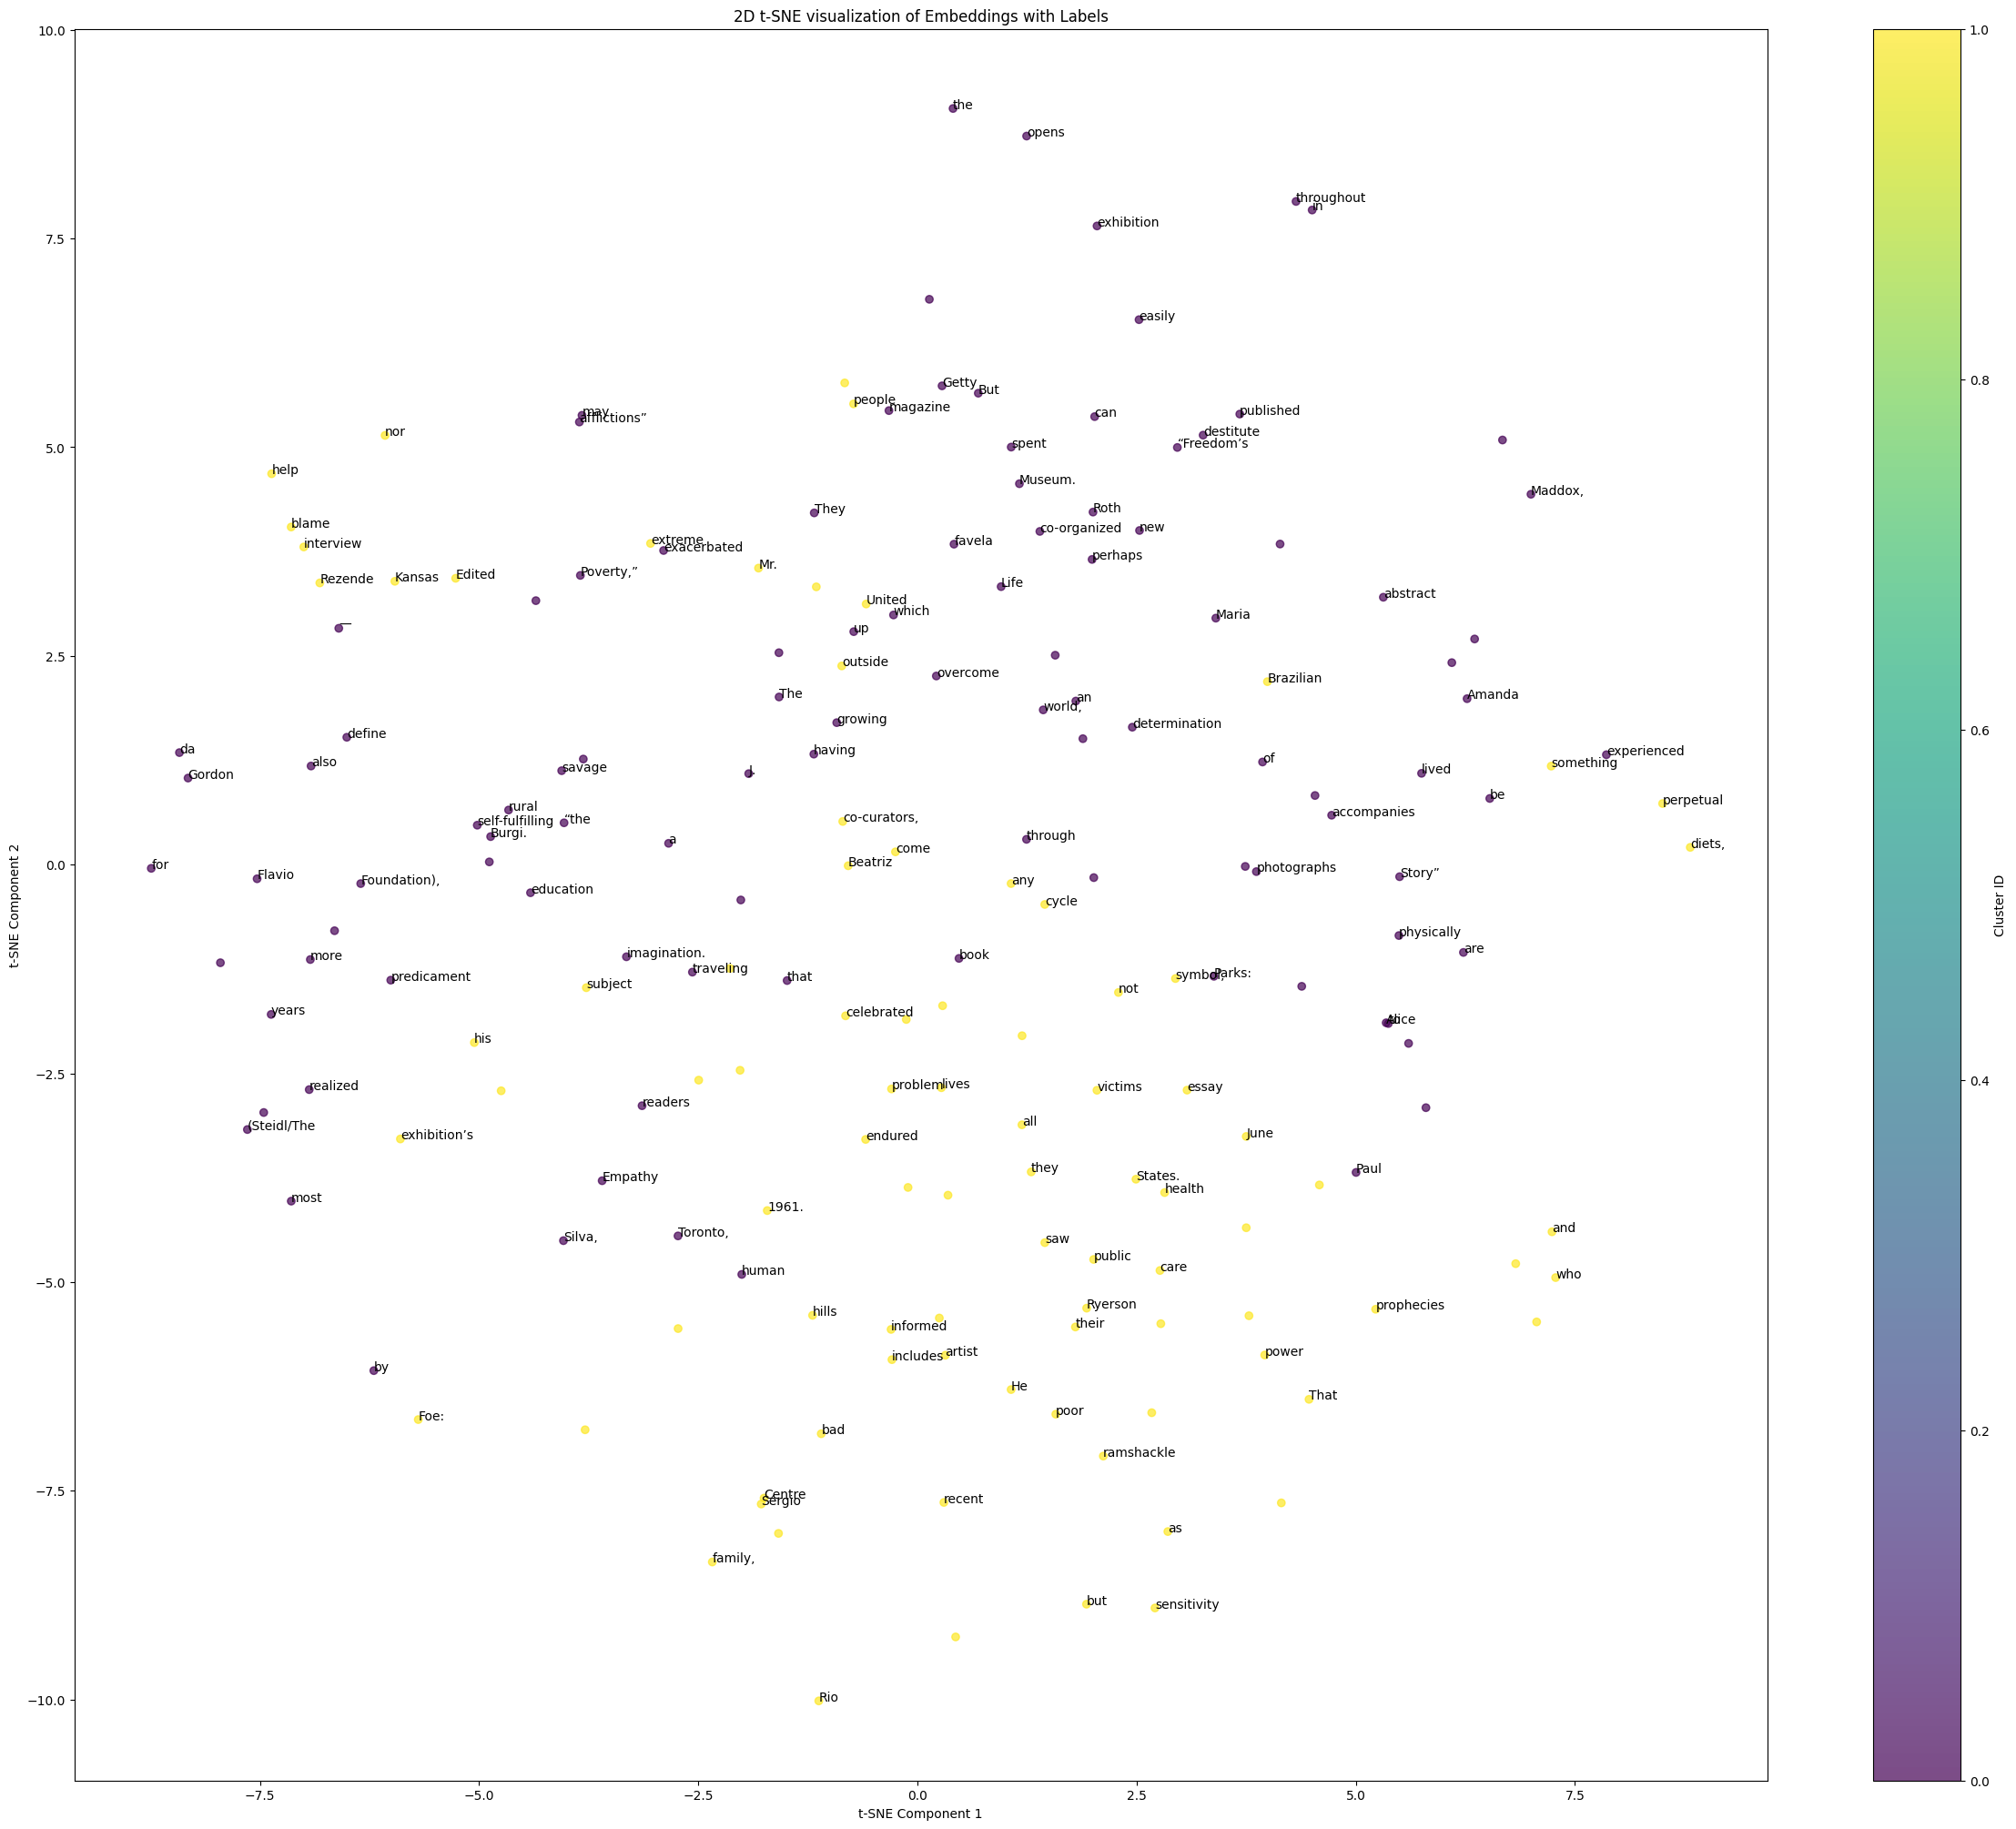

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Assuming word_to_ix is the dictionary that maps words to their corresponding indices

# 1. Load embeddings
embeddings = np.load('embeddings_skipgrams.npy')

# 2. Apply t-SNE for 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# 3. Get cluster assignments (assuming you've already used KMeans before)
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
clusters = kmeans.predict(embeddings)

# 4. 2D Plot
fig, ax = plt.subplots(figsize=(30, 25))
scatter = ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)

# Create a colorbar legend
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Cluster ID')

# Adding labels. For clarity, we'll add labels for a subset of points. 
# You can modify this to add more labels or label specific points of interest.
num_labels = 150  # Change this value as needed
ix_to_word = {ix:word for word, ix in word_to_ix.items()}
indices = np.random.choice(len(embeddings), num_labels, replace=False)  # Random subset of indices

for i in indices:
    ax.text(embeddings_tsne[i, 0], embeddings_tsne[i, 1], ix_to_word[i], size=10, zorder=1, color='k')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('2D t-SNE visualization of Embeddings with Labels')
plt.show()

In [25]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Assuming word_to_ix is the dictionary that maps words to their corresponding indices

# 1. Load embeddings
embeddings = np.load('embeddings_skipgrams.npy')

# 2. Apply t-SNE for 3 dimensions
tsne = TSNE(n_components=3, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# 3. Get cluster assignments (assuming you've already used KMeans before)
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)
clusters = kmeans.predict(embeddings)

# 4. Create a DataFrame for Plotly
import pandas as pd
df = pd.DataFrame(embeddings_tsne, columns=["Component 1", "Component 2", "Component 3"])
df['Cluster'] = clusters
df['Label'] = [ix_to_word[i] for i in range(len(embeddings))]

# 5. 3D Interactive Plot
fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3',
                    color='Cluster', text='Label',
                    opacity=0.7, color_continuous_scale='viridis')

# This will allow you to hover over points and see the labels as tooltips.
# For better performance, you might choose to display a subset of labels instead of all.
fig.update_traces(textposition='top center', selector=dict(mode='markers+text'))

fig.show()


C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\ikaan\AppData\Roaming\Python\Py

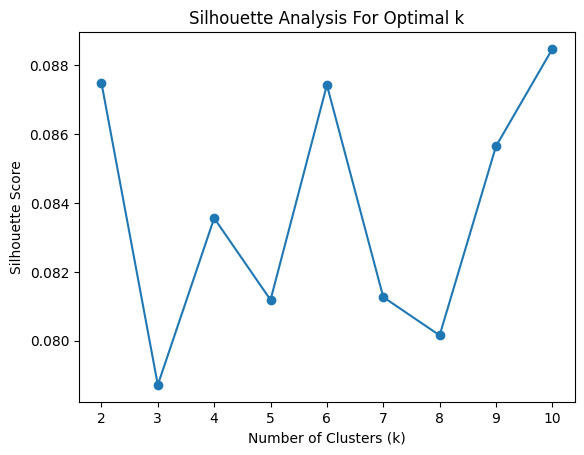

In [26]:
from sklearn.metrics import silhouette_score

sil_scores = []

# Start from 2 clusters, as silhouette score requires more than 1 cluster.
K_range_sil = range(2, 11)

for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    cluster_assignments = kmeans.predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_assignments)
    sil_scores.append(silhouette_avg)

plt.plot(K_range_sil, sil_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()
